In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score

df = pd.read_csv("data/psg_shots_enriched.csv")



In [5]:
# Features & Target
features = ["x", "y", "shot_body_part", "shot_technique", "under_pressure", "shot_first_time","distance_to_goal","angle_to_goal","is_central_zone","is_left_side","is_right_side"]
target = "goal"

X = df[features]
y = df[target]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Colonnes catégorielles vs numériques
cat_features = ["shot_body_part", "shot_technique"]

num_features = ['x', 'y', 'under_pressure', 'shot_first_time',
                'distance_to_goal', 'angle_to_goal',
                'is_central_zone', 'is_left_side', 'is_right_side']

# Pipeline de prétraitement
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_features),
    ("cat", OneHotEncoder(drop='first'), cat_features)
])



### Models Benchmark

In [14]:
from lazypredict.Supervised import LazyClassifier

clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)
models


  0%|          | 0/32 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 75, number of negative: 368
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000095 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 539
[LightGBM] [Info] Number of data points in the train set: 443, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.169300 -> initscore=-1.590595
[LightGBM] [Info] Start training from score -1.590595
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
PassiveAggressiveClassifier,0.77,0.68,0.68,0.77,0.01
NearestCentroid,0.62,0.64,0.64,0.65,0.02
XGBClassifier,0.78,0.64,0.64,0.77,0.06
SGDClassifier,0.82,0.63,0.63,0.79,0.01
Perceptron,0.67,0.62,0.62,0.69,0.01
BernoulliNB,0.77,0.61,0.61,0.76,0.01
KNeighborsClassifier,0.82,0.61,0.61,0.78,0.02
LGBMClassifier,0.77,0.60,0.60,0.75,0.05
LinearDiscriminantAnalysis,0.79,0.58,0.58,0.75,0.01


### Training with the best model

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

# Hyperparameters Optimization using Grid Search
params = {
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.1],
    'classifier__n_estimators': [50, 100],
    'classifier__subsample': [0.7, 1.0]
}

# GridSearchCV with  ROC AUC scoring
grid = GridSearchCV(pipe, params, scoring='roc_auc', cv=5, n_jobs=-1)


grid.fit(X_train, y_train)

print("✅ Best parameters:", grid.best_params_)
print("✅ Best AUC score:", grid.best_score_)
best_model = grid.best_estimator_


✅ Best parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 7, 'classifier__n_estimators': 50, 'classifier__subsample': 1.0}
✅ Best AUC score: 0.6958620264099716


c:\Users\akues\OneDrive\Documents\GitHub\football-xg-analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:01:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [7]:
# Prédictions
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

# Évaluation
print(classification_report(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_proba))



              precision    recall  f1-score   support

           0       0.82      0.95      0.88        87
           1       0.60      0.25      0.35        24

    accuracy                           0.80       111
   macro avg       0.71      0.60      0.62       111
weighted avg       0.77      0.80      0.77       111

AUC: 0.7705938697318008


### Feature importance

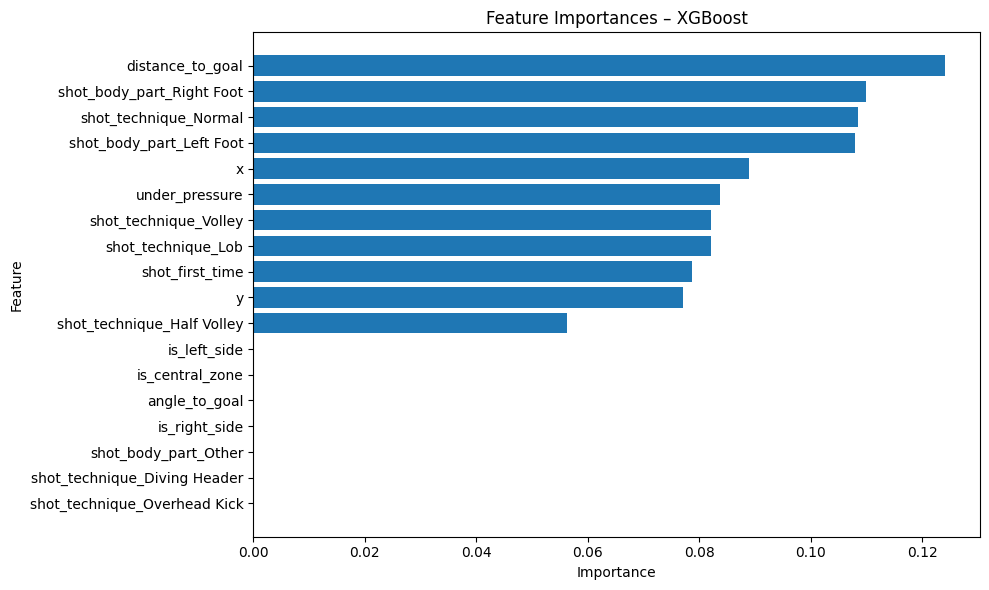

In [ ]:
# Extract the XGBoost classifier from the pipeline
clf = best_model.named_steps['classifier']

# Reconstruct the list of feature names
#    - numerical features
num_feats = num_features
#    - one-hot encoded categorical features
ohe = best_model.named_steps['preprocessor'].named_transformers_['cat']
cat_feats = list(ohe.get_feature_names_out(cat_features))
feature_names = num_feats + cat_feats

# Retrieve feature importances from the classifier
importances = clf.feature_importances_

# Create a DataFrame for sorting
imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

# Plot a horizontal bar chart of feature importances
plt.figure(figsize=(10, 6))
plt.barh(imp_df['feature'], imp_df['importance'])
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importances – XGBoost")
plt.tight_layout()
plt.show()


In [ ]:
import pickle

with open("xgboost.pkl", "wb") as f:
    pickle.dump(grid, f)